In [1]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import copy
import time
import numba as nb
from tqdm import tqdm

In [2]:
dt = 1000
sim_lim = 1000
skip_points = 10
G = 6.67e-11
error = 1
test3_extra_Bodies = 2

def random_Body():
    return CosmicBody(float(rnd.randrange(1e22, 1e23, 1.0e19)),
                      np.array([float(rnd.randrange(-100000, 100000, 100)),
                                float(rnd.randrange(-100000, 100000, 100)),
                                float(rnd.randrange(-100000, 100000, 100))]),
                      np.array([float(rnd.randrange(-1e11, 1e11, 1e8)),
                                float(rnd.randrange(-1e11, 1e11, 1e8)),
                                float(rnd.randrange(-1e11, 1e11, 1e8))]))

In [3]:
@nb.njit
#Function1: Returns norm of vector
def norm(vec: np.ndarray):
    return np.linalg.norm(vec, ord = 2)

@nb.njit
#Function2. Gets on input: Mass and radius. Returns: acceleration
def accelerate(M: float, r: np.ndarray):
    return G * M * r / norm(r) ** 3
    
#Class1:   
class Star:
    #C1.Function1. Gets on input: Mass and radius(def = 0). Returns: None
    def __init__(self, mass: float, radius = 0.):
        self.mass = mass
        self.vec_P = [0, 0, 0]
        self.radius = radius
    #C2.Function2. Gets on input: Name of the star. Returns: All initialased information
    def __str__(self):
        return f"Mass:{self.mass} Radius:{self.radius}"

#Class2:  
class CosmicBody:
    #C2.Function1. Gets on input: Mass, velocity vector, coordinate vector. Returns: None
    def __init__(self, mass: float, vec_v: np.ndarray, vec_P: np.ndarray):
        self.mass = mass
        self.vec_v = vec_v
        self.vec_P = vec_P
        self.coords = ([self.vec_P[0], self.vec_P[1], self.vec_P[2]])
        self.destroy_flag = False
        self.id = id(self)
    #C2.Function2. Gets on input: Name of the body. Returns: All initialased information
    def __str__(self):
        return f"Mass:{self.mass} Velocity:({self.vec_v[0]}, {self.vec_v[1]}, {self.vec_v[2]}) Coordinate:({self.vec_P[0]}, {self.vec_P[1]}, {self.vec_P[2]})"
    #C2.Function3. Gets on input: Name of the body. Returns: Kinetic energy of object
    def E_k(self):
        return self.mass * norm(self.vec_v) ** 2 / 2

#Function3. Gets on input: One body and array of bodies. Returns: None(but checkes is the body destryoed and changed the flag)
def try_destroy(self_Body: CosmicBody, Body: [CosmicBody, Star]):
    if isinstance(Body, Star):
        if norm(self_Body.vec_P - Body.vec_P) < 1000:
            self_Body.destroy_flag = True
    else:
        if norm(self_Body.vec_P - Body.vec_P) < 1000:
            Body.destroy_flag = True
            self_Body.destroy_flag = True

#Function4. Gets on input:One star and list of bodies. Doing 1 iterarion of interaction between bodies in system Returns:None
def gravitate(star: Star, Bodies: list):

    Bodies_copy = copy.deepcopy(Bodies)
    for Body, Body_copy in zip(Bodies, Bodies_copy):
        try_destroy(Body, star)
        Body_copy.destroy_flag = Body.destroy_flag
        if Body.destroy_flag == True:
            continue
        dv = accelerate(star.mass, - Body.vec_P) * dt
        Body.vec_v += dv
        Body.vec_P += Body.vec_v * dt
        for NEW_Body in Bodies:
            if NEW_Body.id != Body.id:
                try_destroy(Body, NEW_Body)
                Body_copy.destroy_flag = Body.destroy_flag
        for Body1 in Bodies_copy:
            if Body1.id == Body.id or Body1.id == True:
                continue
            dv = accelerate(Body1.mass, Body_copy.vec_P - Body1.vec_P)*dt
            Body.vec_v += dv
            Body.vec_P += Body.vec_v * dt
        Body.coords = np.column_stack((Body.coords, [Body.vec_P[0], Body.vec_P[1], Body.vec_P[2]]))
            
#Function6. Gets on input: Names of two Bodies. Returns: potential energy of 2 Bodies     
def E_p(Body1, Body2):
    return G * Body1.mass * Body2.mass / norm(Body1.vec_P - Body2.vec_P)

#Function7. Gets on input: Name of the star and names of two Bodies. Returns full system energy (potential + kinetic)
def E_full(star: Star, Bodies: np.ndarray):
    E = 0
    for i in range(len(Bodies)):
        E += E_p(Bodies[i], star) + Bodies[i].E_k()
        for j in range(i + 1, len(Bodies)):
            E += E_p(Bodies[i], Bodies[j])
    return E

#Function8. Gets on input: Name of the star and names of the Body. Returns: Orbit type of Body.
def orbit_type(star: Star, Body: CosmicBody):
    E = E_p(star, Body) - Body.E_k()
    if E > 0:
        return 'Elliptic'
    elif E < 0:
        return 'Hyperbolic(Leaves an interaction area)'
    else:
        return 'Parabolic(Leaves an interaction area)'    

    
system_of_2 = np.array([random_Body(), random_Body()])
system_of_2_copy = copy.deepcopy(system_of_2)
system_of_3 = np.array([random_Body(), random_Body(), random_Body()])
system_of_4 = np.array([random_Body(), random_Body(), random_Body(), random_Body()])
Сириус = Star(1e31)
zero = Star(0)

Проверка ЗСЭ

In [4]:
def test1(star, Bodies: np.ndarray):
    print('Test №1: Energy error estimation')
    E_initial = E_full(star, Bodies)
    print('Original system full energy:', E_initial)
    i = 0
    E_arr = []
    while np.abs(E_full(star, Bodies)/E_initial - 1) < error and i < sim_lim:
        gravitate(star, Bodies)
        i += 1
        E_arr.append(E_full(star, Bodies))
    print('Finite system full energy:', E_full(star, Bodies))
    if i == sim_lim:
        print(
            f"For {i} iterations we have {round(np.abs(E_full(star, Bodies)/E_initial - 1)*100,1)}% relative error guaranteed")
    else:
        print(f"For {i} iterations needed to guarantee {round(error*100,1)}% relative error(sad)")

test1(Сириус, system_of_2)

Test №1: Energy error estimation
Original system full energy: 1.2129403923345924e+33
Finite system full energy: 8.241809539430551e+32
For 1000 iterations we have 32.1% relative error guaranteed


Проверка на уничтожение

In [5]:
Earth = CosmicBody(1e23, np.array([4., 2., 8.]), np.array([1., 2., 3.]))

def test2(Body1, Body2):
    print('\nTest №2:')
    try_destroy(Earth, Сириус)
    if Earth.destroy_flag == True: 
        print('Destructed sucsessfully')
    else: print('Missed')
    
test2(Earth, Сириус)


Test №2:
Destructed sucsessfully


Действие gravitate со звездой


Test №3:
Mass:2.558e+22 Velocity:(600.0, -14600.0, -29800.0) Coordinate:(-68600000000.0, 35400000000.0, -59900000000.0)
Mass:5.505e+22 Velocity:(95400.0, -70600.0, -76800.0) Coordinate:(22000000000.0, 72500000000.0, -16000000000.0)


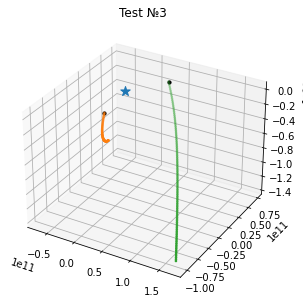

In [6]:
def test3(star, Bodies: np.ndarray):
    print('\nTest №3:')
    for Body in Bodies:
        print(Body)
    for i in range(sim_lim):
        gravitate(star, Bodies)

def test3plot(star, Bodies: np.ndarray):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='3d')
    if star.mass != 0:
        ax.scatter(0, 0, 0, marker='*', s=100)
    for Body in Bodies:
        ax.scatter(Body.coords[0][::skip_points], Body.coords[1][::skip_points],
                   Body.coords[2][::skip_points], marker='.', s=10)
        ax.scatter(Body.coords[0][0], Body.coords[1]
                   [0], Body.coords[2][0], color='black', label='spawn point', s = 10)
    ax.set_title('Test №3')
    ([float(rnd.randrange(-100000, 100000, 100)),
                                float(rnd.randrange(-100000, 100000, 100)),
                                float(rnd.randrange(-100000, 100000, 100))])
test3(Сириус, system_of_2_copy)
test3plot(Сириус, system_of_2_copy)

Проверим моделирование системы, когда в случайные моменты времени появляются новые тела (4Bodies)


Test №3: adding bodies in random time
Random timings: [317000 717000]


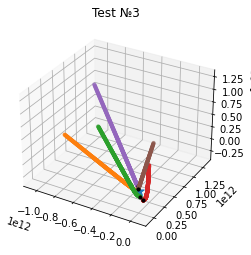

In [7]:
def test3(star, Bodies: np.ndarray):
    print('\nTest №3: adding bodies in random time')
    time = np.array(
        [rnd.randrange(0, sim_lim, 1) * dt for j in range(test3_extra_Bodies)])
    time.sort()
    print('Random timings:', time)
    for t in range(sim_lim):
        if float(t) * dt in time:
            something = random_Body()
            Bodies = np.append(Bodies, something)
        for Body in Bodies:
            gravitate(star, Bodies)
    return Bodies


def test3_plot(star, Bodies: np.ndarray):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    if star.mass != 0:
        ax.scatter(0, 0, 0, marker='*', s=100)
    for Body in Bodies:
        ax.scatter(Body.coords[0][::skip_points], Body.coords[1][::skip_points],
                   Body.coords[2][::skip_points], s = 10)
        ax.scatter(Body.coords[0][0], Body.coords[1]
                   [0], Body.coords[2][0], color = 'Black', label = 'spawn point', s=10)
    ax.set_title('Test №3')
    
    
    
test3_res = test3(Сириус, system_of_3)
test3_plot(Сириус, test3_res)

Проверяем работу функции проверки типа орбиты (orbit_type())


Test №4: testing orbyt_type function
Elliptic


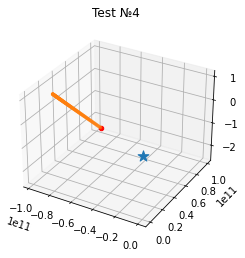

In [8]:
def test4(star, Body):
    print('\nTest №4: testing orbyt_type function')
    print(orbit_type(star, Body))
    for i in range(sim_lim):
        gravitate(star, np.array([Body]))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(star.vec_P[0], star.vec_P[1], star.vec_P[2], marker='*', s = 130)
    ax.scatter(Body.coords[0][::skip_points], Body.coords[1][::skip_points],
                   Body.coords[2][::skip_points], s=7)
    ax.scatter(Body.coords[0][0], Body.coords[1]
               [0], Body.coords[2][0], color='red', label = 'spawn point')
    ax.set_title('Test №4')
    
Body = random_Body()
test4(Сириус, Body)

<IPython.core.display.Javascript object>


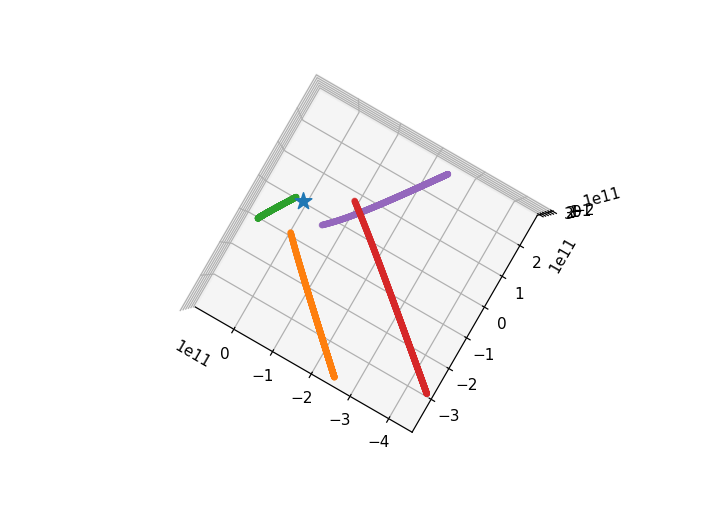

 22%|████████▌                              | 219/1000 [00:38<02:56,  4.43it/s]C:\Users\s\anaconda3\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:70: RuntimeWarning: invalid value encountered in true_divide
  u = u / np.linalg.norm(u)
C:\Users\s\anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:33: RuntimeWarning: invalid value encountered in double_scalars
  a = (a + 180) % 180
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values

In [9]:
%matplotlib notebook
def test_animation(star: Star, Bodies: np.ndarray):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    fig.show()
    fig.canvas.draw()
    
    for t in tqdm(np.arange(0., sim_lim * dt, dt)):
        angle = 60 + 60 * t / sim_lim 
        gravitate(star, Bodies)
        ax.clear()
        
        ax.scatter(0, 0, 0, marker = '*', s = 130)
        for Body in Bodies:
            ax.scatter(Body.coords[0][::int(skip_points/10)], Body.coords[1][::int(skip_points/10)],
                   Body.coords[2][::int(skip_points/10)], s = 10)
        ax.view_init(30 - angle * 0.2, angle)
        fig.canvas.draw()
    
test_animation(Сириус, system_of_4)